<a href="https://colab.research.google.com/github/hrk022/stock_predictor/blob/main/stock_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance vaderSentiment torch torchvision scikit-learn matplotlib pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests

In [ ]:
tickter = "AAPL"
df_stock = yf.download(tickter, start="2020-01-01",end="2024-12-31")[["Open","Close"]]
df_stock.reset_index(inplace=True)
df_stock["Date"] = pd.to_datetime(df_stock["Date"])

[*********************100%***********************]  1 of 1 completed


In [ ]:
API_KEY = "10c053c8a02e41b9b6cfc0e63e75578c"
query = "Apple Inc"
url = (
    f"https://newsapi.org/v2/everything?"
    f"q={query}&"
    f"apiKey={API_KEY}"
)

response = requests.get(url)
data = response.json()

if "articles" in data:
  articles = data["articles"]
  news_data = pd.DataFrame([{
      'Date': pd.to_datetime(article['publishedAt']).date(),
      'Headline': article['title']
  }for article in articles])
  print(news_data.head())
else:
  print("No articles found in the response.")

         Date                                           Headline
0  2025-06-09   tvOS 26 is Compatible With These Apple TV Models
1  2025-06-12  Take a Break From WWDC 2025 With Apple's Chill...
2  2025-06-03  Apple Shares WWDC 2025 Playlist With One Hour ...
3  2025-05-20  Apple Outlines WWDC 2025 Labs and Community Ev...
4  2025-05-26  iOS 19 Design Changes Rumored to Extend to App...


In [ ]:
analyzer = SentimentIntensityAnalyzer()
news_data["Sentiment"] = news_data["Headline"].apply(lambda text: analyzer.polarity_scores(text)['compound'])

sentiment_daily = news_data.groupby("Date")["Sentiment"].mean().reset_index()

In [ ]:
# Step 1: Reset index WITHOUT duplicating 'index' column
df_stock = df_stock.reset_index(drop=True)

# Step 2: Flatten MultiIndex columns
df_stock.columns = ['_'.join(filter(None, col)) if isinstance(col, tuple) else col for col in df_stock.columns]

# Step 3: Ensure both 'Date' columns match type
df_stock['Date'] = pd.to_datetime(df_stock['Date']).dt.date
sentiment_daily['Date'] = pd.to_datetime(sentiment_daily['Date']).dt.date

# Step 4: Merge safely
data = pd.merge(df_stock, sentiment_daily, on='Date', how='left')

# Step 5: Fill missing sentiment values
data['Sentiment'].fillna(0, inplace=True)

# Done
print(data.head())


         Date  Open_AAPL  Close_AAPL  Sentiment
0  2020-01-02  71.627092   72.620842        0.0
1  2020-01-03  71.847118   71.914818        0.0
2  2020-01-06  71.034709   72.487846        0.0
3  2020-01-07  72.497506   72.146919        0.0
4  2020-01-08  71.849525   73.307503        0.0


<ipython-input-34-943080829>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Sentiment'].fillna(0, inplace=True)


In [ ]:
print(df_stock.columns)
print(df_stock.index.names)


Index(['Date', 'Open_AAPL', 'Close_AAPL'], dtype='object')
[None]


In [ ]:
scaler = MinMaxScaler()
scaled_data  = scaler.fit_transform(data[['Open_AAPL', 'Close_AAPL','Sentiment']])

def create_sequence(data, seq_length):
  xs,ys = [], []
  for i in range(len(data) - seq_length):
    x = data[i:i+seq_length]
    y = data[i+seq_length][1]
    xs.append(x)
    ys.append(y)
  return np.array(xs), np.array(ys)

In [ ]:
SEQ_LEN = 10
X, y = create_sequence(scaled_data, SEQ_LEN)

X_tensor = torch.tensor(X, dtype=torch.float32)        # shape: (samples, seq_len, 3)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [ ]:
dataset = TensorDataset(X_tensor,y_tensor)
dataloader = DataLoader(dataset, batch_size=32,shuffle=True)

In [ ]:
class DualHeadLSTM(nn.Module):
  def __init__(self, input_size=3, hidden_size=64, num_layers=2):
    super(DualHeadLSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.regressor = nn.Linear(hidden_size, 1)
    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, 1),
        nn.Sigmoid()
    )
  def forward(self,x):
    lstm_out, _ = self.lstm(x)
    last_hidden = lstm_out[:, -1, :]
    price = self.regressor(last_hidden)
    direction = self.classifier(last_hidden)
    return price, direction

In [ ]:
model = DualHeadLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_reg = nn.MSELoss()
loss_cls = nn.BCELoss()

# Labels for direction (1 if price goes up, 0 if down)
y_dir = (y_tensor[1:] > y_tensor[:-1]).float()  # shift y to compare previous day
y_tensor = y_tensor[1:]
X_tensor = X_tensor[:-1]

EPOCHS = 100
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for i in range(0, len(X_tensor), 32):
        xb = X_tensor[i:i+32]
        yb_price = y_tensor[i:i+32]
        yb_dir = y_dir[i:i+32]

        pred_price, pred_dir = model(xb)

        loss1 = loss_reg(pred_price, yb_price)
        loss2 = loss_cls(pred_dir, yb_dir)

        loss = loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 27.9307
Epoch 2, Loss: 30.8083
Epoch 3, Loss: 28.3583
Epoch 4, Loss: 27.8914
Epoch 5, Loss: 27.2188
Epoch 6, Loss: 27.0768
Epoch 7, Loss: 27.0499
Epoch 8, Loss: 27.0315
Epoch 9, Loss: 27.0308
Epoch 10, Loss: 27.0308
Epoch 11, Loss: 27.0279
Epoch 12, Loss: 27.0268
Epoch 13, Loss: 27.0268
Epoch 14, Loss: 27.0263
Epoch 15, Loss: 27.0250
Epoch 16, Loss: 27.0226
Epoch 17, Loss: 27.0191
Epoch 18, Loss: 27.0151
Epoch 19, Loss: 27.0112
Epoch 20, Loss: 27.0080
Epoch 21, Loss: 27.0054
Epoch 22, Loss: 27.0034
Epoch 23, Loss: 27.0017
Epoch 24, Loss: 27.0000
Epoch 25, Loss: 26.9983
Epoch 26, Loss: 26.9967
Epoch 27, Loss: 26.9951
Epoch 28, Loss: 26.9935
Epoch 29, Loss: 26.9920
Epoch 30, Loss: 26.9905
Epoch 31, Loss: 26.9890
Epoch 32, Loss: 26.9875
Epoch 33, Loss: 26.9860
Epoch 34, Loss: 26.9846
Epoch 35, Loss: 26.9832
Epoch 36, Loss: 26.9819
Epoch 37, Loss: 26.9806
Epoch 38, Loss: 26.9795
Epoch 39, Loss: 26.9785
Epoch 40, Loss: 26.9776
Epoch 41, Loss: 26.9763
Epoch 42, Loss: 26.9743
E

In [ ]:
model.eval()
with torch.no_grad():
    pred_price, pred_dir = model(X_tensor)
    pred_price = pred_price.numpy().flatten()
    pred_dir = pred_dir.numpy().flatten()  # Sigmoid output between 0 and 1


In [ ]:
import numpy as np

# Rebuild 3-column arrays with dummy values for Open and Sentiment
pred_scaled = np.hstack((
    np.zeros((len(pred_price), 1)),          # dummy Open
    pred_price.reshape(-1, 1),               # predicted Close
    np.zeros((len(pred_price), 1))           # dummy Sentiment
))
actual_scaled = np.hstack((
    np.zeros((len(y_tensor), 1)),
    y_tensor.numpy().reshape(-1, 1),         # actual Close
    np.zeros((len(y_tensor), 1))
))

# Inverse transform
predicted_prices = scaler.inverse_transform(pred_scaled)[:, 1]
actual_prices = scaler.inverse_transform(actual_scaled)[:, 1]


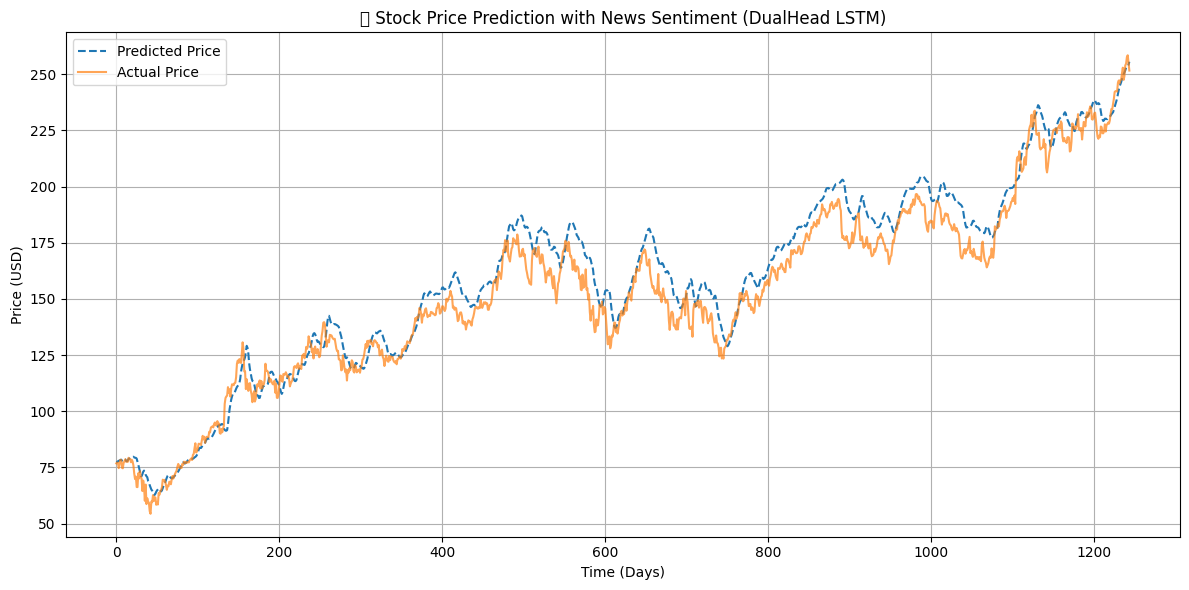

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(predicted_prices, label='Predicted Price', linestyle='--')
plt.plot(actual_prices, label='Actual Price', alpha=0.7)
plt.title("📊 Stock Price Prediction with News Sentiment (DualHead LSTM)")
plt.xlabel("Time (Days)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), "stock_model.pt")
from google.colab import files
files.download("stock_model.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>